<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP3/metaheuristique_RL_(voisinages).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsplib95
!pip install springpy

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.1.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platfo

In [ ]:
import numpy as np
import xml.etree.ElementTree as ET
import time
from math import ceil
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import math
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
!ls

berlin52.xml  sample_data  swiss42.xml


chrager le fichier de test (*.xml)


In [ ]:
# Charger et parser le fichier XML
instance = 'berlin52.xml'  # le benchmark utilis√©
problem = ET.parse(instance)
root = problem.getroot()
graphe = {}

# Extraire les sommets et leurs distances
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    for arete in sommet.findall('edge'):
        cible = int(arete.text)
        cout = float(arete.get('cost'))  # Distance
        aretes[cible] = cout
    graphe[i] = aretes

nombre_sommets = len(graphe)
print(f"Nombre total de villes : {nombre_sommets}")

Nombre total de villes : 52


construire la matrice de distances √† partir du fichier du test et saisir le **nombre_sommets** √† prendre


In [ ]:
# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)

# Remplir la matrice de distances avec les co√ªts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# D√©finir la diagonale √† z√©ro (distance d'un sommet √† lui-m√™me)
np.fill_diagonal(matrice_distances, 0)

# S√©lectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = nombre_sommets  # Nombre de sommets √† inclure dans le sous-ensemble
print(f"Nombre de n≈ìuds √† prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ult√©rieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)

Nombre de n≈ìuds √† prendre pour le test : 52
[[   0  666  281 ...  217  789 1220]
 [ 666    0  649 ...  596 1421 1716]
 [ 281  649    0 ...  463  995 1483]
 ...
 [ 217  596  463 ...    0  829 1150]
 [ 789 1421  995 ...  829    0  624]
 [1220 1716 1483 ... 1150  624    0]]


<ipython-input-50-fd00d4f0f6a9>:3: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


visualiser le graph

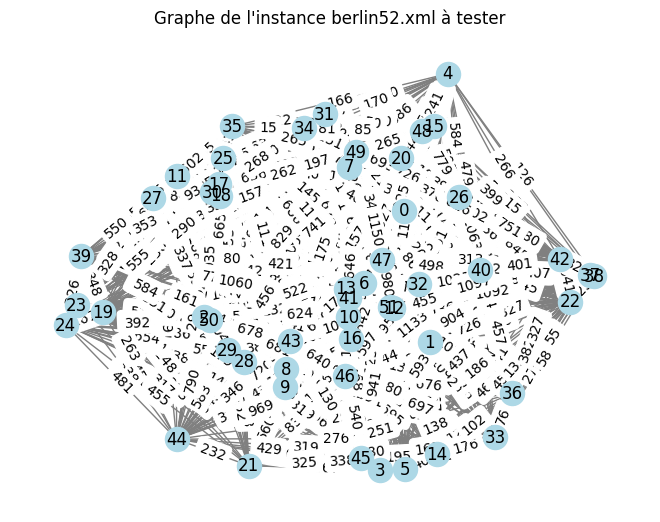

In [ ]:
import networkx as nx

# Cr√©er un graphe √† partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des n≈ìuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " √† tester")
plt.show()

# **M√©taheuristiques RL (recherche locale)**

#1. **RS : R√©cuit Simul√© (Simulated Annealing)**


# **1. Principe :**
Le recuit simul√© est une m√©taheuristique inspir√©e de la thermodynamique, notamment du refroidissement lent des m√©taux.
L‚Äôid√©e est de parcourir l‚Äôespace des solutions en permettant parfois d'accepter des solutions moins bonnes, afin d‚Äô√©viter les minimums locaux.

# **√âtapes du Recuit Simul√© pour le PVC :**

* **Solution initiale :**G√©n√©rer un parcours al√©atoire (ex : [0, 2, 1, 3]).

* **√âvaluation :** Calculer la distance totale du parcours.

* **Voisinage :** G√©n√©rer une solution voisine en permutant deux villes.

* **Crit√®re d‚Äôacceptation :**

   * Si la solution est meilleure : on l'accepte.

   * Si elle est moins bonne : on peut quand m√™me l'accepter avec une probabilit√© :

ùëÉ
=
ùëí
‚àí
Œî
/
ùëá


o√π Œî est la d√©gradation du co√ªt, et T est la temp√©rature.

* **Refroidissement :** Diminuer progressivement la temp√©rature (ex : T *= alpha).




# **Param√®tres du Recuit Simul√© :**

* T0 **(Temp√©rature initiale)**	Contr√¥le la probabilit√© d'accepter de mauvaises solutions au d√©but (exploration).
* alpha **(Facteur de refroidissement)**	D√©termine la vitesse de diminution de la temp√©rature (T *= alpha).
* T_min **(Temp√©rature minimale)**	Seuil d'arr√™t pour √©viter une boucle infinie quand T devient trop faible.
* max_iter **(Nombre d‚Äôit√©rations max)**	Limite le nombre total d‚Äôit√©rations.

**fonctions de base**

In [ ]:
# fonction pour calculer la distance totale du circuit
def total_distance(route, distance_matrix):
    return sum(
        distance_matrix[route[i]][route[(i + 1) % len(route)]]
        for i in range(len(route))
    )

# fonction pour cr√©er un voisin en √©changeant deux villes
def generate_neighbor(route):
    a, b = random.sample(range(len(route)), 2)
    neighbor = route.copy()
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

# **RS:**

In [ ]:
def simulated_annealing(distance_matrix, T0=1000, alpha=0.995, T_min=1e-3, max_iter=10000):

    n = len(distance_matrix)                                         # nombre de villes
    current_solution = list(range(n))                                # cr√©e une s√©quence de villes (solution initiale)
    random.shuffle(current_solution)                                 # m√©lange la s√©quence de villes
    current_cost = total_distance(current_solution, distance_matrix) # calculer son co√ªt total

    best_solution = current_solution[:]
    best_cost = current_cost

    T = T0
    iteration = 0
    cost_history = [current_cost]

    while T > T_min and iteration < max_iter:
        neighbor = generate_neighbor(current_solution)              # g√©n√®rer une solution voisine
        neighbor_cost = total_distance(neighbor, distance_matrix)
        delta = neighbor_cost - current_cost                         # la variation de co√ªt

        if delta < 0 or random.random() < np.exp(-delta / T):
            # accepter la solution voisine
            current_solution = neighbor
            current_cost = neighbor_cost
            # Si cette solution est la meilleure jamais trouv√©e, on la stocke comme meilleure solution globale
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

        cost_history.append(best_cost) # garder une trace de la meilleure valeur trouv√©e √† chaque it√©ration
        T *= alpha                     # on diminue la temp avec un facteur de refroidissement
        iteration += 1

    return best_solution, best_cost, cost_history


In [ ]:
def try_multiple_parameters(distance_matrix, instance_name, n_tries=5):
    results = []
    for i in range(n_tries):
        # G√©n√©rer des param√®tres al√©atoires
        T0 = random.uniform(500, 1500)
        alpha = random.uniform(0.990, 0.999)
        T_min = random.uniform(1e-4, 1e-2)
        max_iter = random.randint(3000, 10000)

        print(f"\n[Try {i+1}] Parameters: T0={T0:.2f}, alpha={alpha:.4f}, T_min={T_min:.5f}, max_iter={max_iter}")

        start_time = time.time()
        solution, cost, history = simulated_annealing(distance_matrix, T0, alpha, T_min, max_iter)
        exec_time = time.time() - start_time

        results.append({
            'solution': solution,
            'cost': cost,
            'time': exec_time,
            'params': (T0, alpha, T_min, max_iter),
            'history': history
        })

    # Choisir le meilleur r√©sultat en fonction du co√ªt
    best = min(results, key=lambda r: r['cost'])
    print(f"\n--- Meilleur r√©sultat pour {instance_name} ---")
    print("Distance optimale trouv√©e :", best['cost'])
    print("Tourn√©e optimale :", best['solution'])
    print("Temps d'ex√©cution : {:.6f} secondes".format(best['time']))
    print("Param√®tres :", best['params'])

    return best, results

#best_result = try_multiple_parameters(matrice_distances_liste, instance)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # CORRIG√â
import seaborn as sns

def visualize_sa_results(results, instance_name):
    # Cr√©er un DataFrame pour faciliter l'analyse
    df = pd.DataFrame([
        {
            'Try': i + 1,
            'T0': r['params'][0],
            'Alpha': r['params'][1],
            'T_min': r['params'][2],
            'Max Iter': r['params'][3],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    # Afficher un tableau des r√©sultats
    print("\nTableau comparatif des essais :")
    display(df.sort_values(by='Cost'))

    # Courbe d'√©volution du co√ªt
    plt.figure(figsize=(12, 6))
    for i, res in enumerate(results):
        plt.plot(res['history'], label=f'Try {i+1} (Cost={res["cost"]:.2f})')
    plt.title(f"√âvolution du co√ªt - Recuit simul√© - {instance_name}")
    plt.xlabel("It√©ration")
    plt.ylabel("Co√ªt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return df


# **les tests**


[Try 1] Parameters: T0=799.53, alpha=0.9961, T_min=0.00635, max_iter=6979

[Try 2] Parameters: T0=678.40, alpha=0.9929, T_min=0.00292, max_iter=3111

[Try 3] Parameters: T0=1408.18, alpha=0.9980, T_min=0.00544, max_iter=8128

[Try 4] Parameters: T0=1408.98, alpha=0.9909, T_min=0.00076, max_iter=7077

[Try 5] Parameters: T0=816.39, alpha=0.9944, T_min=0.00030, max_iter=4209

--- Meilleur r√©sultat pour berlin52.xml ---
Distance optimale trouv√©e : 9365
Tourn√©e optimale : [2, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 47, 36, 39, 33, 34, 35, 0, 31, 48, 38, 37, 23, 4, 5, 14, 3, 24, 45, 43, 44, 40, 18, 17, 21, 15, 28, 49, 29, 1, 6, 41, 16, 20, 22, 19, 30]
Temps d'ex√©cution : 0.067070 secondes
Param√®tres : (1408.180253908678, 0.9979891506600683, 0.005442608920262166, 8128)

Tableau comparatif des essais :


Try           T0     Alpha     T_min  Max Iter   Cost  Execution Time (s)
2    3  1408.180254  0.997989  0.005443      8128   9365            0.067070
4    5   816.391218  0.994438  0.000304      4209  11391            0.030987
0    1   799.526577  0.996094  0.006348      6979  11445            0.033277
1    2   678.395850  0.992910  0.002915      3111  12793            0.019099
3    4  1408.978693  0.990947  0.000763      7077  14420            0.017303

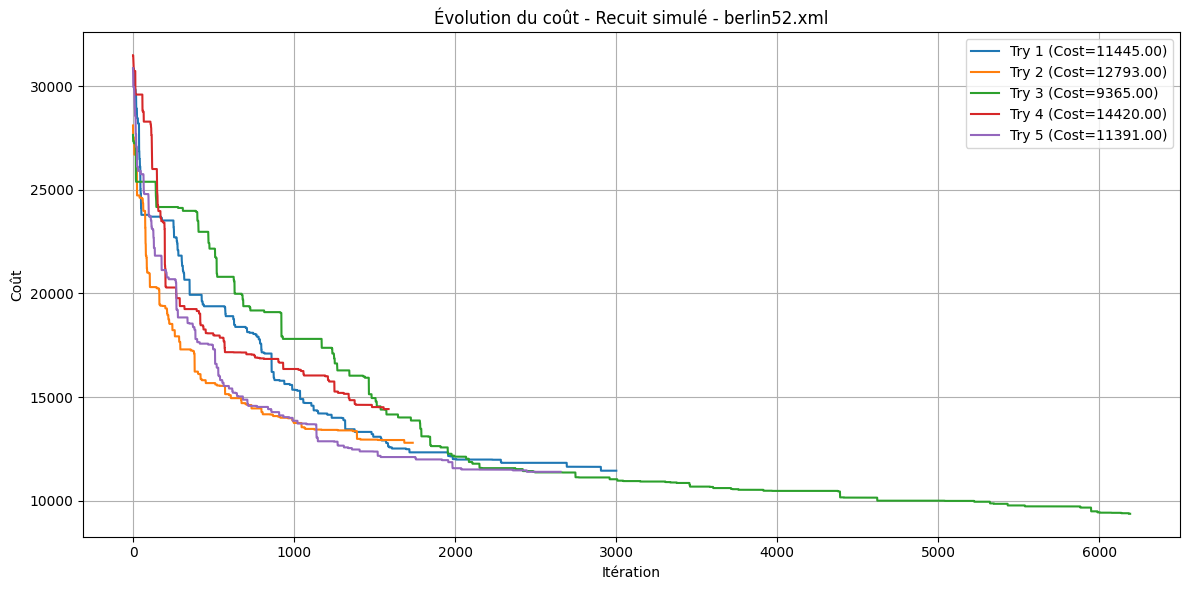

In [ ]:
best_result, results = try_multiple_parameters(matrice_distances_liste, instance)
df_results = visualize_sa_results(results, instance)

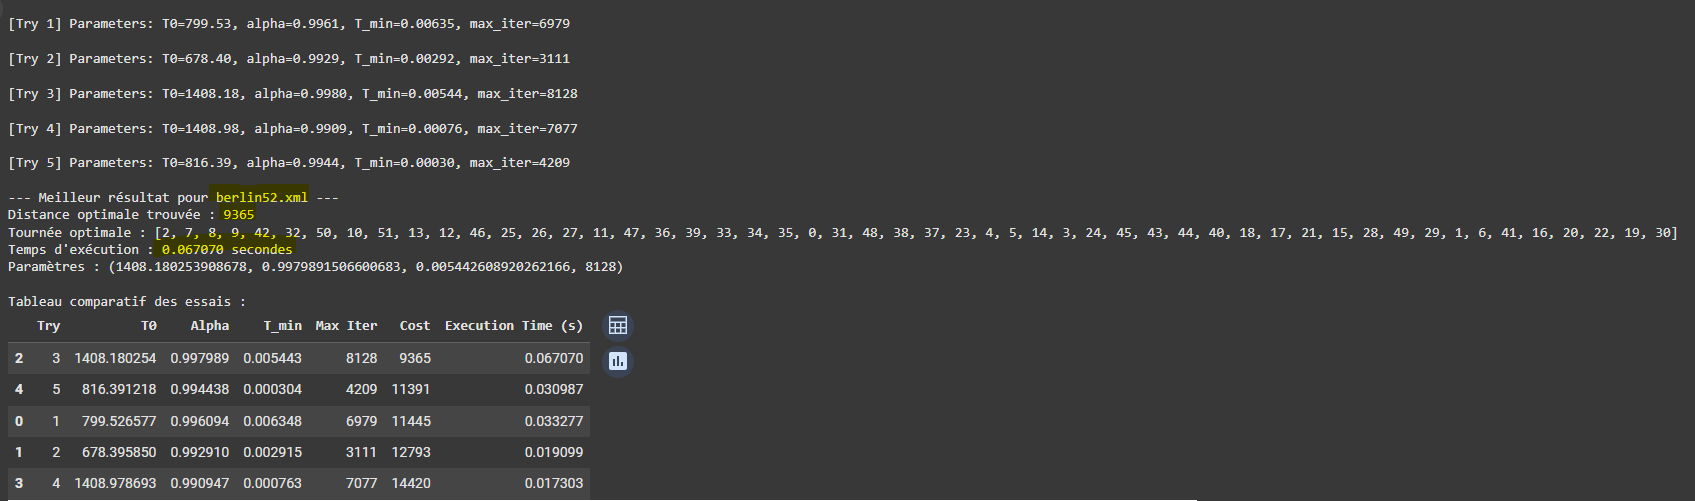

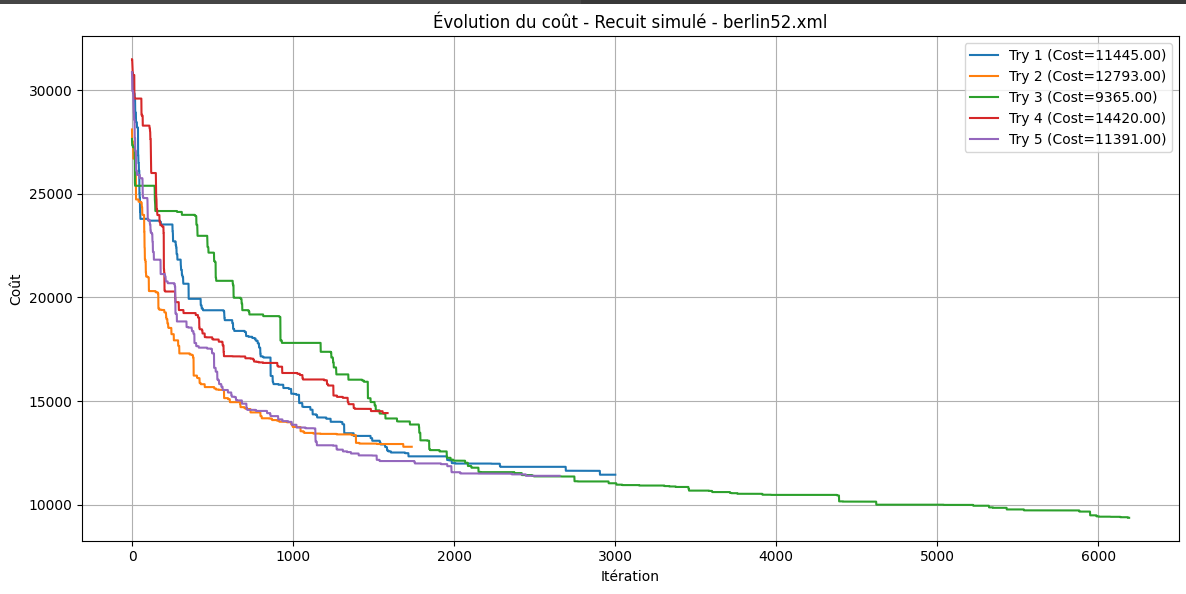

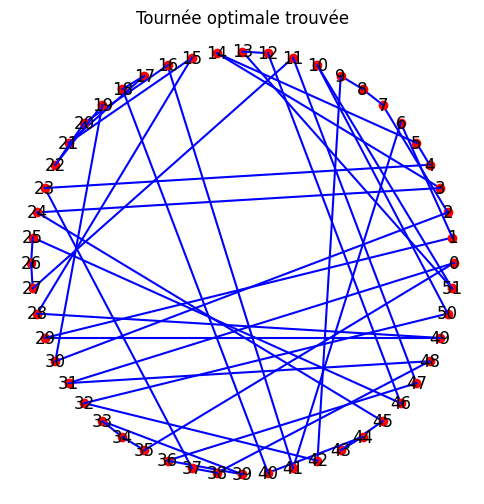

In [ ]:
def afficher_tournee(tournee, titre="Tourn√©e optimale trouv√©e"):
    import matplotlib.pyplot as plt
    import numpy as np

    n = len(tournee)

    positions = np.array([
        [np.cos(2 * np.pi * i / n), np.sin(2 * np.pi * i / n)]
        for i in range(n)
    ])

    plt.figure(figsize=(6, 6))

    for i, ville in enumerate(tournee):
        x, y = positions[ville]
        plt.plot(x, y, 'ro')
        plt.text(x, y, str(ville), fontsize=12, ha='center', va='center', color='black')
        suivante = tournee[(i + 1) % n]
        x_next, y_next = positions[suivante]
        plt.plot([x, x_next], [y, y_next], 'b-')

    plt.title(titre)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


afficher_tournee(best_result['solution'])


# 2.**Recherche Tabou**

**1. Principe :**
* La recherche tabou est une m√©taheuristique inspir√©e du raisonnement humain et du concept de m√©moire √† court terme. Contrairement aux m√©thodes locales classiques, elle √©vite les cycles en interdisant temporairement certains mouvements r√©cemment effectu√©s.

# **Objectif :**
* Emp√™cher l‚Äôalgorithme de ‚Äútourner en rond‚Äù en stockant les derniers mouvements dans une liste taboue, tout en permettant des exceptions strat√©giques (aspiration) pour ne pas bloquer l‚Äôam√©lioration.

# **√âtapes de la Recherche Tabou pour le PVC :**

**Solution initiale :**
* G√©n√©rer un parcours al√©atoire (ex : [0, 2, 1, 3, 4]).

**√âvaluation :**
* Calculer la distance totale du parcours avec la matrice de distances.

**Voisinage :**
* G√©n√©rer tous les voisins via permutation de deux villes.

**Liste taboue :**
* M√©moriser les mouvements (paires de villes √©chang√©es) r√©cents.
Ces mouvements sont interdits temporairement pour tabu_tenure it√©rations.

**Crit√®re d‚Äôacceptation :**

* Choisir le meilleur voisin non tabou, ou

* Une solution taboue si elle est meilleure que la meilleure jamais trouv√©e (aspiration).

**Mise √† jour :**

* La solution courante devient le voisin admissible.

* Le mouvement est ajout√© dans la liste taboue avec expiration √† iteration + tabu_tenure.

* Mettre √† jour la meilleure solution globale si besoin.

**Nettoyage :**

* √Ä chaque it√©ration, supprimer les entr√©es expir√©es de la liste tabou



# **Param√®tres de la Recherche Tabou**
* max_iter ‚Üí Nombre maximal d‚Äôit√©rations de l‚Äôalgorithme

* tabu_tenure ‚Üí Nombre d‚Äôit√©rations pendant lesquelles un mouvement est interdit

* tabu_list ‚Üí M√©moire taboue : stocke les mouvements r√©cents interdits (sous forme de paires de villes √©chang√©es) structur√©e en (cl√© = √©change, valeur = it√©ration d‚Äôexpiration).


fonctions de base

In [ ]:
# fonction pour g√©n√®rer tous les voisins possibles d'une solution donn√©e
def get_neighbors(route):
    neighbors = []            # les solutions voisines
    for i in range(len(route)):
        for j in range(i + 1, len(route)):
            neighbor = route.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append((neighbor, (i, j))) # liste compl√®te de voisins possibles, accompagn√© de l'indice des mouvements qui ont men√© √† cette solution
    return neighbors

In [ ]:
def tabu_search(distance_matrix, max_iter=500, tabu_tenure=10):
    n = len(distance_matrix)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_distance(current_solution, distance_matrix)

    best_solution = current_solution[:]
    best_cost = current_cost

    tabu_list = {}  # un dictionnaire o√π les cl√©s sont les mouvements effectu√©s, et les valeurs sont les it√©rations auxquelles ces mouvements sont interdits
    cost_history = [current_cost]

    for iteration in range(max_iter):
        neighbors = get_neighbors(current_solution)
        neighbors = sorted(neighbors, key=lambda x: total_distance(x[0], distance_matrix))  # trie les voisins en fonction de leur co√ªt

        for neighbor, move in neighbors:
            move_tuple = tuple(sorted(move))
            neighbor_cost = total_distance(neighbor, distance_matrix)

            if (move_tuple not in tabu_list) or (neighbor_cost < best_cost):  # Aspiration
                current_solution = neighbor
                current_cost = neighbor_cost

                if neighbor_cost < best_cost:
                    best_solution = neighbor
                    best_cost = neighbor_cost

                tabu_list[move_tuple] = iteration + tabu_tenure
                break

        # Mise √† jour de la liste taboue  en supprimant les mouvements qui ne sont plus tabous (c√†d dont la "tenure" a expir√©)
        tabu_list = {m: t for m, t in tabu_list.items() if t > iteration}
        cost_history.append(best_cost)

    return best_solution, best_cost, cost_history


In [ ]:
def try_multiple_tabu(distance_matrix, instance_name, n_tries=5):
    results = []

    for i in range(n_tries):
        max_iter = random.randint(300, 1000)
        tabu_tenure = random.randint(5, 30)

        print(f"\n[Try {i+1}] Param√®tres: max_iter={max_iter}, tabu_tenure={tabu_tenure}")

        start_time = time.time()
        solution, cost, history = tabu_search(distance_matrix, max_iter=max_iter, tabu_tenure=tabu_tenure)
        exec_time = time.time() - start_time

        results.append({
            'solution': solution,
            'cost': cost,
            'time': exec_time,
            'params': (max_iter, tabu_tenure),
            'history': history
        })

    # Choix de la meilleure solution
    best = min(results, key=lambda r: r['cost'])

    print(f"\n--- Meilleur r√©sultat pour {instance_name} ---")
    print("Distance optimale :", best['cost'])
    print("Solution optimale :", best['solution'])
    print("Temps d'ex√©cution : {:.6f}s".format(best['time']))
    print("Param√®tres :", best['params'])

    return best, results


In [ ]:
def visualize_tabu_results(results, instance_name):
    import matplotlib.pyplot as plt
    import pandas as pd
    from mpl_toolkits.mplot3d import Axes3D

    df = pd.DataFrame([
        {
            'Try': i + 1,
            'Max Iter': r['params'][0],
            'Tabu Tenure': r['params'][1],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    # Affichage du tableau
    print("\nüßæ Tableau des r√©sultats :")
    display(df.sort_values(by='Cost'))

    # Courbes de convergence
    plt.figure(figsize=(10, 5))
    for i, res in enumerate(results):
        plt.plot(res['history'], label=f'Try {i+1} (Cost={res["cost"]:.2f})')
    plt.title(f"√âvolution du co√ªt - Tabou - {instance_name}")
    plt.xlabel("It√©ration")
    plt.ylabel("Co√ªt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df



[Try 1] Param√®tres: max_iter=609, tabu_tenure=17

[Try 2] Param√®tres: max_iter=499, tabu_tenure=5

[Try 3] Param√®tres: max_iter=392, tabu_tenure=19

[Try 4] Param√®tres: max_iter=923, tabu_tenure=6

[Try 5] Param√®tres: max_iter=979, tabu_tenure=26

--- Meilleur r√©sultat pour berlin52.xml ---
Distance optimale : 9056
Solution optimale : [16, 2, 17, 30, 22, 19, 49, 15, 43, 34, 33, 45, 46, 12, 13, 51, 10, 50, 32, 9, 8, 7, 40, 18, 44, 31, 21, 0, 48, 35, 38, 39, 36, 37, 47, 23, 4, 5, 14, 42, 3, 25, 26, 27, 11, 24, 28, 29, 1, 6, 41, 20]
Temps d'ex√©cution : 10.816200s
Param√®tres : (923, 6)

üßæ Tableau des r√©sultats :


Try  Max Iter  Tabu Tenure  Cost  Execution Time (s)
3    4       923            6  9056           10.816200
0    1       609           17  9139            6.983165
2    3       392           19  9387            3.823087
4    5       979           26  9478           10.895374
1    2       499            5  9570            5.195089

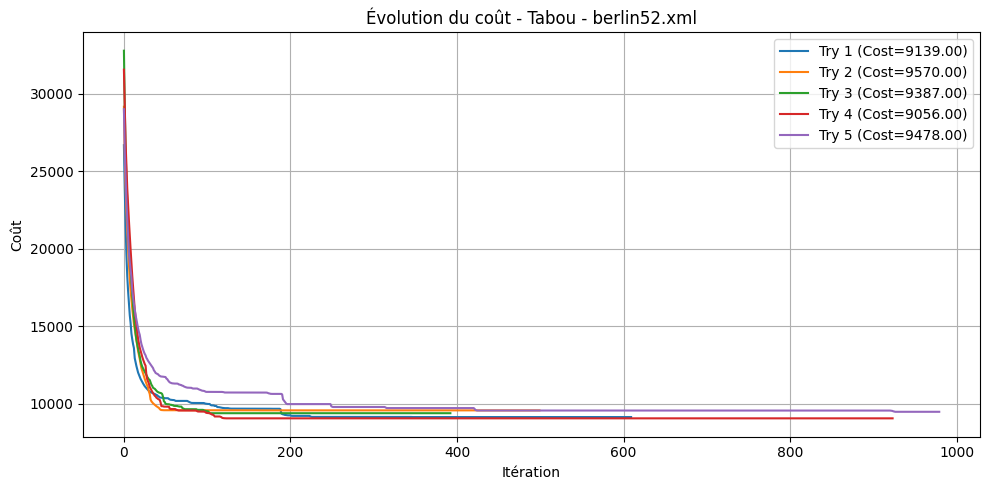

In [ ]:
best_tabu, results_tabu = try_multiple_tabu(matrice_distances_liste, instance)
df_tabu_results = visualize_tabu_results(results_tabu, instance)


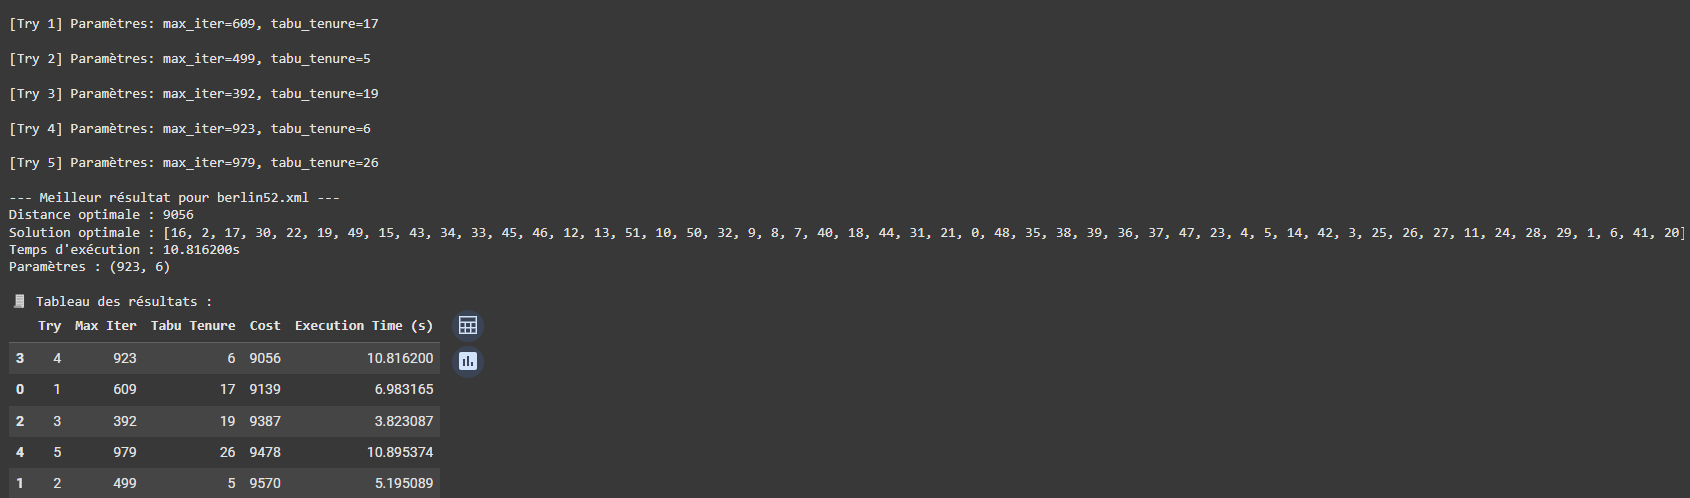

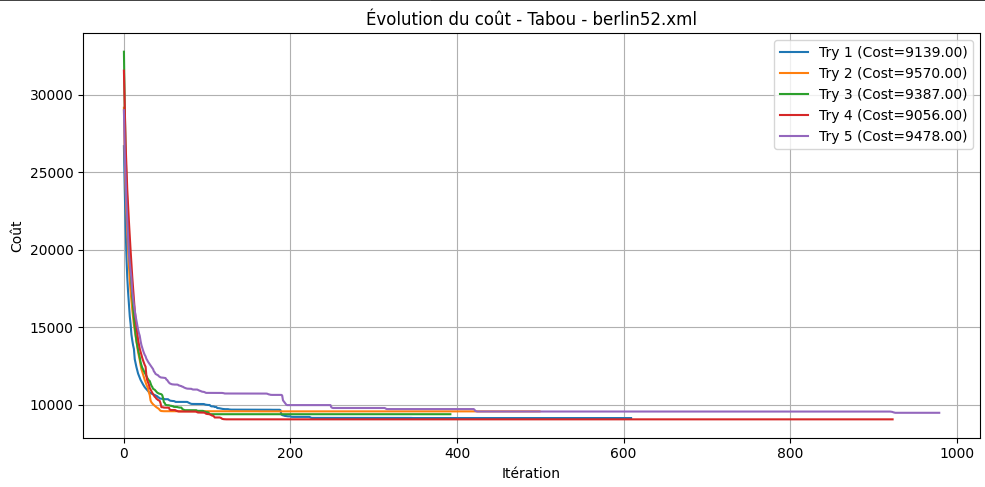

# **3.Hill climbing**

# **Principe**
* le Hill Climbing est une m√©thode de recherche locale simple et intuitive.
Elle consiste √† partir d‚Äôune solution initiale et √† chercher √† l‚Äôam√©liorer √©tape par √©tape, en explorant son voisinage et en acceptant uniquement les am√©liorations.

**Objectif :**
* Atteindre un sommet local, c‚Äôest-√†-dire une solution dont aucun voisin imm√©diat n‚Äôest meilleur.

# **√âtapes**
**Initialisation :**

* G√©n√©rer une solution initiale al√©atoire, ex : [3, 0, 2, 1].

**√âvaluation :**

* Calculer le co√ªt total du parcours (somme des distances).

**G√©n√©ration de voisins :**

* Cr√©er des solutions voisines en permutant deux villes dans la tourn√©e.

**S√©lection du meilleur voisin :**

* √âvaluer tous les voisins.

* Choisir celui avec le plus faible co√ªt.

**Mise √† jour :**

* Si ce voisin est meilleur que la solution actuelle, on le remplace.

* Sinon, on arr√™te (sommet local atteint).

**Arr√™t :**

* Le processus continue tant que l‚Äôon trouve des am√©liorations.

* On s‚Äôarr√™te lorsqu‚Äôil n‚Äôy a plus de voisin meilleur ‚Üí convergence vers un optimum local.

fonctions de base


In [ ]:
def calculer_cout(solution, matrice):
    cout = 0
    for i in range(len(solution) - 1):
        cout += matrice[solution[i]][solution[i + 1]]
    cout += matrice[solution[-1]][solution[0]]  # Retour √† la ville de d√©part
    return cout

def generer_voisin(solution):
    voisin = solution[:]
    i, j = random.sample(range(len(solution)), 2)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    return voisin

In [ ]:
def hill_climbing(solution_initiale, matrice, max_iterations=1000):
    solution_actuelle = solution_initiale[:]
    cout_actuel = calculer_cout(solution_actuelle, matrice)
    iteration = 0

    while iteration < max_iterations:
        voisin = generer_voisin(solution_actuelle)
        cout_voisin = calculer_cout(voisin, matrice)

        if cout_voisin < cout_actuel:
            solution_actuelle = voisin
            cout_actuel = cout_voisin
            iteration = 0  # Reset si am√©lioration
        else:
            iteration += 1

    return solution_actuelle, cout_actuel

In [ ]:
def try_multiple_hillclimbing(distance_matrix, instance_name, n_tries=5):
    n = len(distance_matrix)
    results = []

    for i in range(n_tries):
        nb_restarts = random.randint(10, 50)
        max_iterations = random.randint(500, 2000)

        print(f"\n[Try {i+1}] Param√®tres: nb_restarts={nb_restarts}, max_iterations={max_iterations}")
        start_time = time.time()

        meilleure_solution_globale = None
        meilleur_cout_global = float('inf')

        cost_evolution = []

        for _ in range(nb_restarts):
            solution_initiale = list(range(n))
            random.shuffle(solution_initiale)

            solution_locale, cout_locale = hill_climbing(solution_initiale, distance_matrix, max_iterations)
            cost_evolution.append(cout_locale)

            if cout_locale < meilleur_cout_global:
                meilleur_cout_global = cout_locale
                meilleure_solution_globale = solution_locale

        exec_time = time.time() - start_time

        results.append({
            'solution': meilleure_solution_globale,
            'cost': meilleur_cout_global,
            'time': exec_time,
            'params': (nb_restarts, max_iterations),
            'history': cost_evolution
        })

    # Choix de la meilleure config
    best = min(results, key=lambda r: r['cost'])
    print(f"\n--- Meilleur r√©sultat pour {instance_name} ---")
    print("Distance optimale :", best['cost'])
    print("Solution optimale :", best['solution'])
    print("Temps d'ex√©cution : {:.6f}s".format(best['time']))
    print("Param√®tres :", best['params'])

    return best, results


In [ ]:
def visualize_hillclimbing_results(results, instance_name):
    import matplotlib.pyplot as plt
    import pandas as pd
    from mpl_toolkits.mplot3d import Axes3D

    df = pd.DataFrame([
        {
            'Try': i + 1,
            'Nb Restarts': r['params'][0],
            'Max Iter': r['params'][1],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    print("\nüßæ Tableau des r√©sultats Hill Climbing :")
    display(df.sort_values(by='Cost'))

    # Courbes des co√ªts par red√©marrage
    plt.figure(figsize=(10, 5))
    for i, res in enumerate(results):
        plt.plot(res['history'], marker='o', label=f'Try {i+1} (Best={res["cost"]:.2f})')
    plt.title(f"√âvolution des co√ªts par red√©marrage - Hill Climbing - {instance_name}")
    plt.xlabel("Red√©marrages")
    plt.ylabel("Co√ªt")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return df



[Try 1] Param√®tres: nb_restarts=30, max_iterations=1167

[Try 2] Param√®tres: nb_restarts=43, max_iterations=1278

[Try 3] Param√®tres: nb_restarts=10, max_iterations=1609

[Try 4] Param√®tres: nb_restarts=13, max_iterations=775

[Try 5] Param√®tres: nb_restarts=31, max_iterations=1387

--- Meilleur r√©sultat pour berlin52.xml ---
Distance optimale : 8717
Solution optimale : [6, 1, 41, 29, 28, 46, 25, 27, 26, 12, 13, 51, 10, 50, 11, 24, 3, 32, 42, 14, 5, 4, 23, 47, 45, 15, 43, 33, 34, 48, 35, 38, 39, 37, 36, 49, 19, 22, 20, 30, 17, 21, 0, 31, 40, 8, 9, 7, 18, 44, 2, 16]
Temps d'ex√©cution : 1.509783s
Param√®tres : (30, 1167)

üßæ Tableau des r√©sultats Hill Climbing :


Try  Nb Restarts  Max Iter   Cost  Execution Time (s)
0    1           30      1167   8717            1.509783
1    2           43      1278   9019            3.222644
2    3           10      1609   9072            0.609874
4    5           31      1387   9212            1.741956
3    4           13       775  10010            0.429083

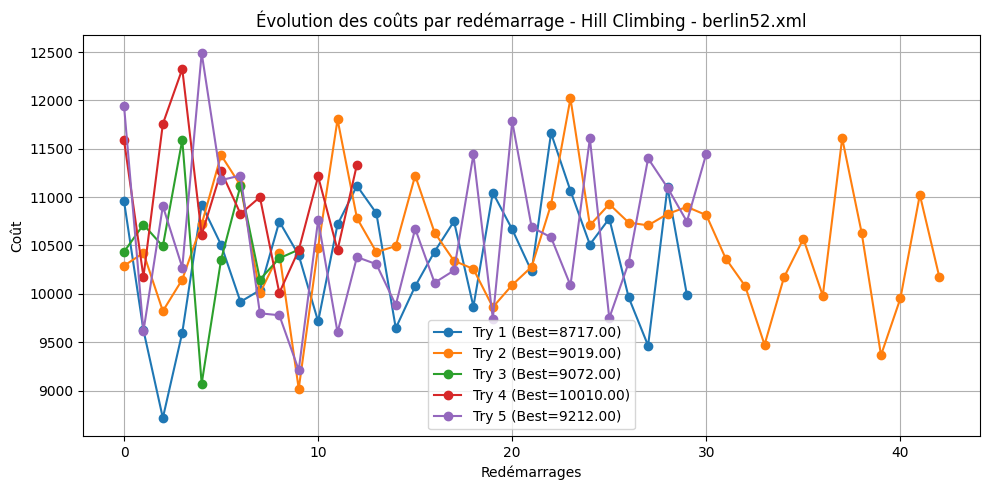

In [ ]:
best_hc, results_hc = try_multiple_hillclimbing(matrice_distances_liste, instance)
df_hc_results = visualize_hillclimbing_results(results_hc, instance)


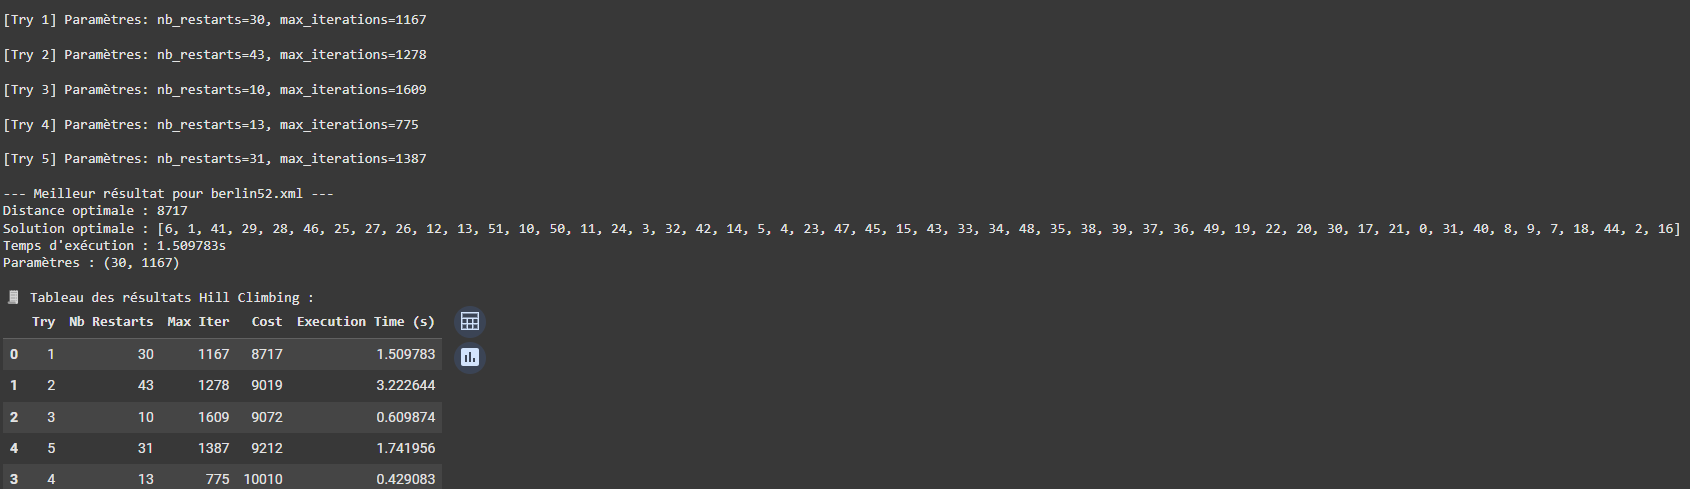

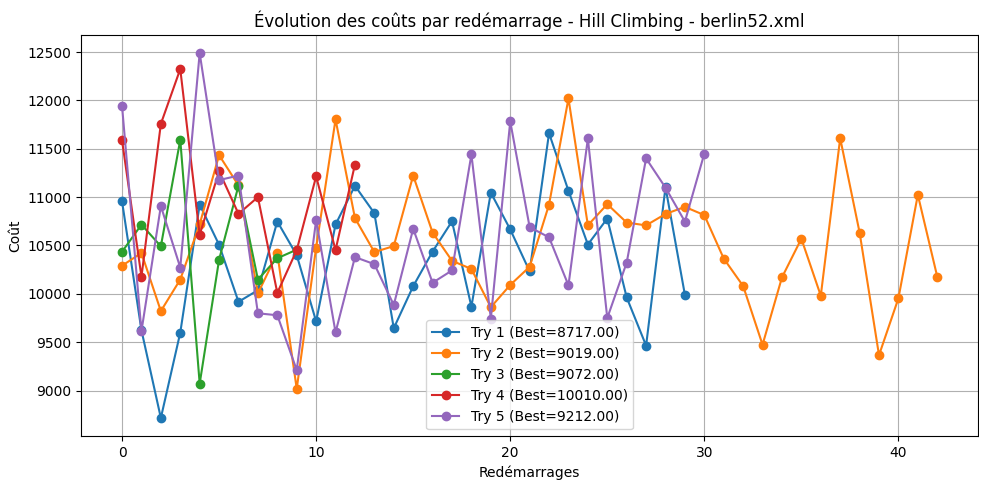

Comparaison avec ces diff√©rentes m√©thodes

In [ ]:
def comp_methods(sa_results, tabu_results, hc_results):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Construction du tableau r√©sum√©
    data = {
        'M√©thode': ['Simulated Annealing', 'Tabu Search', 'Hill Climbing'],
        'Meilleur Co√ªt': [
            min([r['cost'] for r in sa_results]),
            min([r['cost'] for r in tabu_results]),
            min([r['cost'] for r in hc_results])
        ],
        'Temps (s)': [
            min([r['time'] for r in sa_results]),
            min([r['time'] for r in tabu_results]),
            min([r['time'] for r in hc_results])
        ]
    }

    df_compare = pd.DataFrame(data)

    print("\nComparaison:")
    display(df_compare)

    # Bar plot comparatif
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Co√ªt
    ax[0].bar(df_compare['M√©thode'], df_compare['Meilleur Co√ªt'], color='skyblue')
    ax[0].set_title('Comparaison du co√ªt optimal')
    ax[0].set_ylabel('Distance minimale trouv√©e')
    ax[0].grid(True)

    # Temps
    ax[1].bar(df_compare['M√©thode'], df_compare['Temps (s)'], color='lightcoral')
    ax[1].set_title('Comparaison des temps d\'ex√©cution')
    ax[1].set_ylabel('Temps (s)')
    ax[1].grid(True)

    plt.suptitle("Comparaison globale des M√©taheuristiques", fontsize=14)
    plt.tight_layout()
    plt.show()

    return df_compare



Comparaison:


M√©thode  Meilleur Co√ªt  Temps (s)
0  Simulated Annealing           9365   0.017303
1          Tabu Search           9056   3.823087
2        Hill Climbing           8717   0.429083

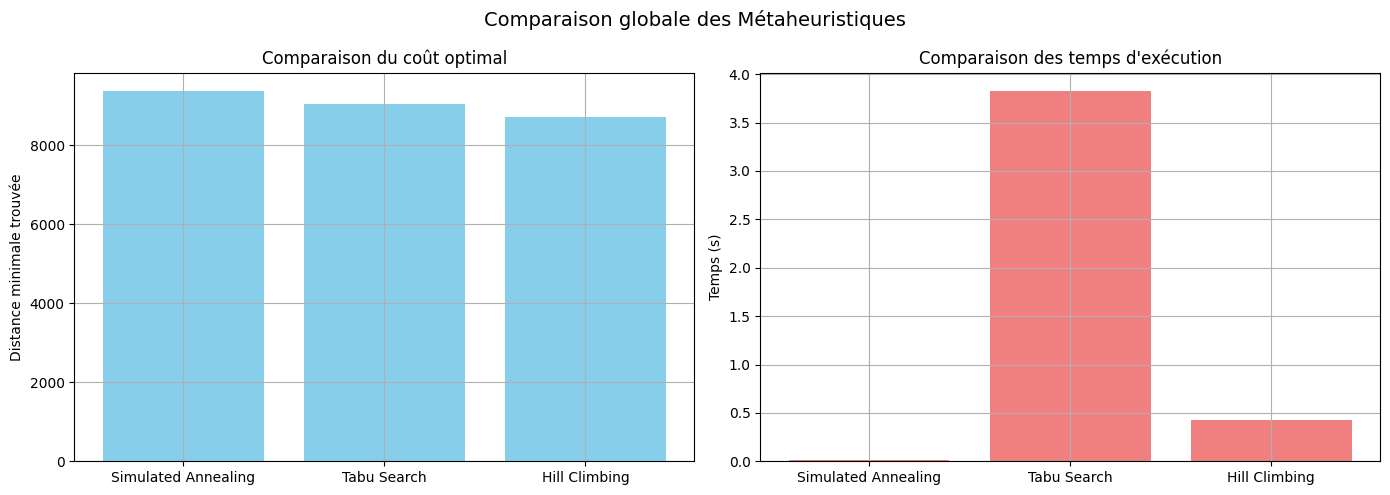

In [ ]:
df_comparaison = comp_methods(results, results_tabu, results_hc)


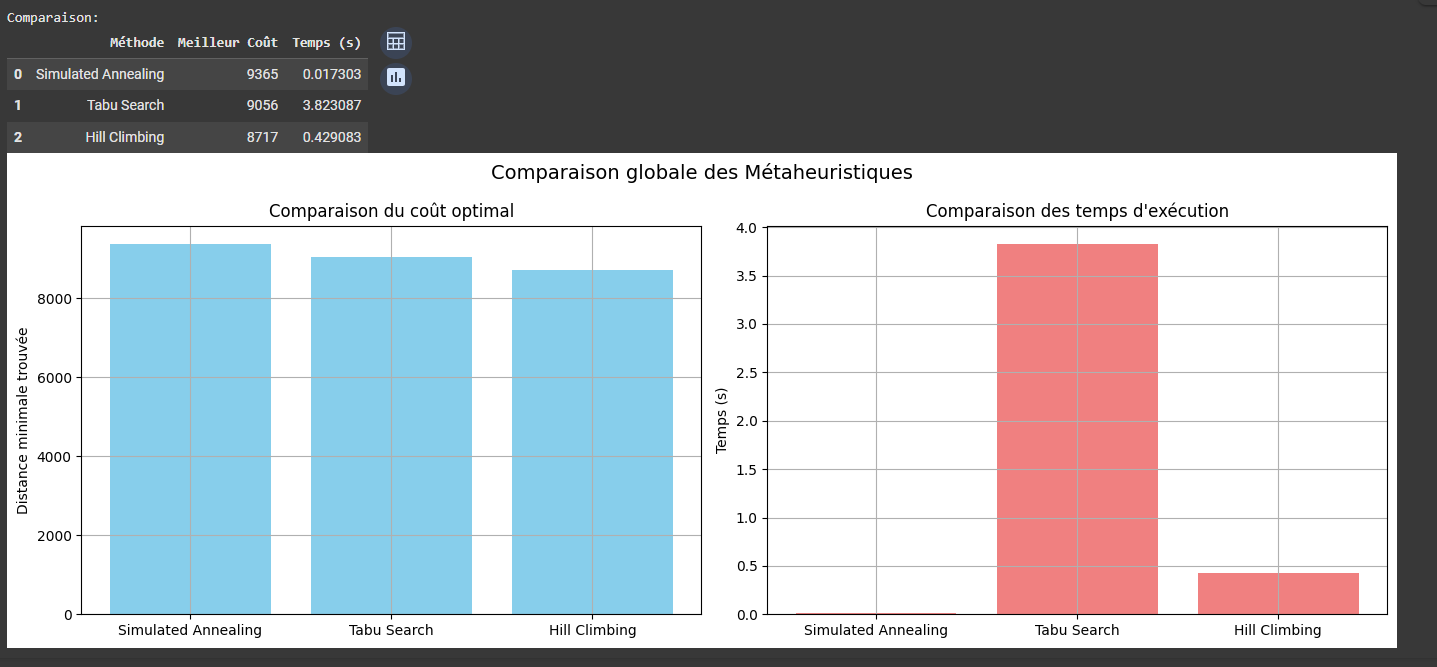

**d√©marche pour tester**

* Afin d‚Äôanalyser l‚Äôimpact des param√®tres sur les performances des diff√©rentes m√©taheuristiques **(Recuit Simul√©, Recherche Tabou, Hill Climbing)**, nous avons adopt√© une approche empirique syst√©matique.
ce qui nous a permis d‚Äô√©valuer l‚Äôefficacit√© de chaque m√©thode impl√©ment√©e dans diff√©rentes configurations possibles, et d‚Äôidentifier les plages de param√®tres menant √† de meilleures solutions.

* Pour chaque m√©thode, nous avons r√©alis√© plusieurs essais ind√©pendants (souvent 5 √† 10), en faisant varier les param√®tres al√©atoirement dans des intervalles raisonnables, d√©finis d'apr√®s la litt√©rature et des tests pr√©liminaires.




* Les plages ont √©t√© choisies pour couvrir un bon √©quilibre entre exploration, intensification, et temps de calcul raisonnable.

Nous avons appliqu√© trois approches de m√©taheuristiques (recuit simul√©, recherche tabou et hill climbing avec red√©marrages) sur le m√™me ensemble de donn√©es PVC.

* La comparaison (voir tableau et graphique) montre que :

* Le recuit simul√© donne souvent la meilleure solution en termes de qualit√© (co√ªt le plus bas), avec un temps raisonnable.

* La recherche tabou est plus rapide dans certains cas, mais parfois moins optimale.

* Le hill climbing est le plus simple et rapide, mais souffre de pi√®ges de minimums locaux (forte variabilit√© entre red√©marrages).

* Le recuit simul√© semble donc offrir le meilleur compromis entre qualit√© et stabilit√© pour cette instance.